In [1]:
import json
import os.path
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

from xcube.core.store import new_data_store
from xcube.core.geom import rasterize_features
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.resampling.affine import affine_transform_dataset
from xcube.core.gridmapping import GridMapping

from cate.util.im.cmap_lc import register_lc_color_map

register_lc_color_map()

In [2]:
def cache_dataset(ds, path, off=False, force=False):
    if off:
        return ds
    if force or not os.path.exists(path):
        ds.to_zarr(path, mode="w")
    return xr.open_zarr(path) 

def time_to_year(ds):
    years = [pd.Timestamp(t.values).year for t in ds.time]
    return ds.assign_coords(time=xr.DataArray(years, dims='time'))

def sort_lc(ds, year):
    ds = ds.sel(time=year)
    ds = ds.chunk(dict(lat=2000, lon=2000))
    # lc_dataset_subset_year = cache_dataset(
    #    lc_dataset_subset_year, 
    #    f'lc_dataset_subset_year_{desired_country}.zarr'
    #)
    lc = ds.lccs_class
    lc_groups = lc.groupby(lc)
    lc_counts = lc_groups.count()
    return lc_counts

---
### Inspect CCI-Toolbox' Zarr Store (high performance data access)

_We connect to the ESA CCI Open Data Portal (ODP). It contains a large number of Essential Climate Variables (ECVs).  
We open the so-called zarr-store within the ODP which contains most relevant ECVs in a very fast access mode.  
The content of the data store is listed to show which ECVs are included._

In [3]:
store = new_data_store('ccizarr')

In [4]:
list(store.get_data_ids())

['BICEP-OC-L3S-PP-MERGED-1M_MONTHLY_9km_mapped-1998-2020-fv4.2.zarr',
 'ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2018-fv2.0.zarr',
 'ESACCI-GHG-L2-CH4-SCIAMACHY-WFMD-2002-2011-fv1.zarr',
 'ESACCI-GHG-L2-CO2-SCIAMACHY-WFMD-2002-2012-fv1.zarr',
 'ESACCI-ICESHEETS_Antarctica_GMB-2002-2016-v1.1.zarr',
 'ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr',
 'ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_NOAA-1982-2016-fv3.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2018-fv1.0.zarr',
 'ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr',
 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
 'ESACCI-OC-L3S-IOP-MERGED-1M_MONTHLY_4km_GEO_PML_OCx_QAA-1997-2020-fv5.0.zarr',
 'ESACCI-PERMAFROST-L4-ALT-MODISLST-AREA4_PP-1997-2018-fv02.0.zarr',
 'ESACCI-SEAICE-L3C-SITHICK-RA2_ENVISAT-NH25KMEASE2-2002-2012-fv2.0.zarr',
 'ESACCI-SEAICE-L3C-SITHICK-RA2_ENVISAT-NH25KMEASE2-2002-2012-fv2_4326.zarr',
 'ESACCI-SEAICE-L3C-SITHICK-RA2_ENVISAT-NH25KMEASE2-2002-2012-fv2_repro.zarr',
 'ESACCI-SEAICE-L3C-SITHICK

---
### Open Soil Moisture ECV

_Our interest is with Soil Moisture. The ECV dataset of the ODP contains a large number of variables. Our interest is the the volumetric soil moisture and its uncertainty.  
In order to save memory and time we drop those variables we are not interested in.  
The "sm_datatest" can be inspected. It has global coverage with 0.25° spacing, resulting in 720 grid cells in latitude and 1440 in longitude.  
It has daily temporal resolution and covers 43 years, from 01. November 1978 until 31.12.2020. It is a multi-mission synthesis, as can be seen from the meta data._

In [5]:
drop_variables = ['t0', 'freqbandID', 'sensor', 'mode', 'dnflag', 'flag']  # Not needed; we do not load them to save time and memory
sm_dataset = store.open_data('ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2020-fv05.3.zarr', 
                             drop_variables=drop_variables)
sm_dataset

<xarray.Dataset>
Dimensions:         (lat: 720, lon: 1440, time: 15402)
Coordinates:
  * lat             (lat) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time            (time) datetime64[ns] 1978-11-01 1978-11-02 ... 2020-12-31
Data variables:
    sm              (time, lat, lon) float32 dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.7
    cdm_data_type:              Grid
    comment:                    This dataset was produced with funding of the...
    contact:                    cci_sm_contact@eodc.eu
    creator_email:              cci_sm_contact@eodc.eu
    creator_name:               Department of Geodesy and Geoinformation, Tec...
    ...                         ...
    time_coverage_duration:     P42Y
    time_coverage_end:          2020-12-31 00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1978-11-01 00:00:00
    title:                      ESA CCI Surface Soil Moisture COMBINED active...
    tracking_id:                174f51a4-6a06-4352-a712-4d3f77bd8166

_We look at the global distribution of soil moisture on the first day in the dataset and compare it to the one 43 days laters.  
While the data from 1978 are from a single instrument (Nimbus 7) and thus the single overpasses can be clearly seen, in 2020  
there were several satellites contributing to the dataset and we get a fairly good global coverage every day. The Scientists working  
on the algorithm within the ESA CCI programme have paid a lot of attention to harmonise the various input data in order to get a consistent  
long term time series._

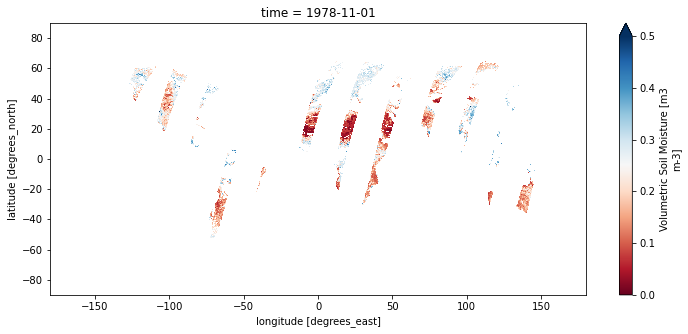

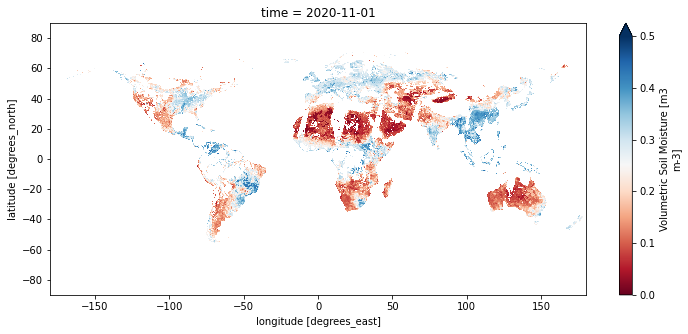

In [7]:
sm_dataset.sel(time="1978-11-01").sm.plot.imshow(cmap='RdBu', vmin = 0, vmax =0.5, figsize=(12, 5))
sm_dataset.sel(time="2020-11-01").sm.plot.imshow(cmap='RdBu', vmin = 0, vmax =0.5, figsize=(12, 5))

_Climate data require uncertainties to unleash their full potential. All CCI datasets are delivered with uncertainties where this is  
possible. Thanks to the multiple observations from different satellites this is possible for the later soil moisture data. The uncertainties  
are one order of magnitude smaller than the soil moisture observations in wet areas but are larger in the dry areas (compare the scale)_

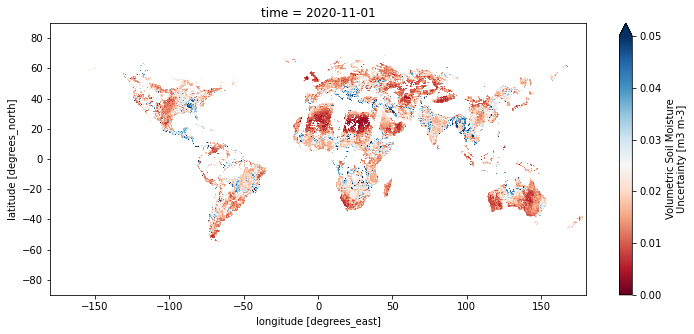

In [8]:
sm_dataset.sel(time="2020-11-01").sm_uncertainty.plot.imshow(cmap='RdBu',  vmin = 0, vmax =0.05, figsize=(12, 5))

---
### Create a spatial subset of Spain

_We will now have a closer look to the time series in Spain and here specifically to the area of Valencia.  
The country border geometry is a useful auxiliary data which is included in the CCI Cate Toolbox environment._

<AxesSubplot:>

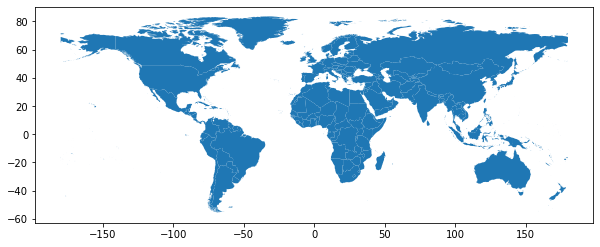

In [9]:
# Open Country Geometries
with open('../resources/countries-50m.geojson') as fp:
    features = json.load(fp)
features

features = gpd.GeoDataFrame.from_features(features)
features.plot(figsize=(10, 10))

In [10]:
desired_country = 'Spain'
valencia = dict(lon=-0.367, lat=39.482) # we will need it later

desired_feature = features.loc[features['sovereignt'] == desired_country]

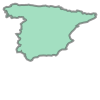

In [11]:
desired_geometry = desired_feature.iloc[0].geometry.geoms[11]
desired_geometry

---
### Investigate the 43 (28) year's time series Soil Moisture for Spain and specifically the area of Valencia

In [13]:
# subset the soil moisture data over Spain
sm_dataset_subset = mask_dataset_by_geometry(sm_dataset, desired_geometry, all_touched=True)
sm_dataset_subset = sm_dataset_subset.sel(time=slice("1992-01-01",None))
# sm_dataset_subset.sm

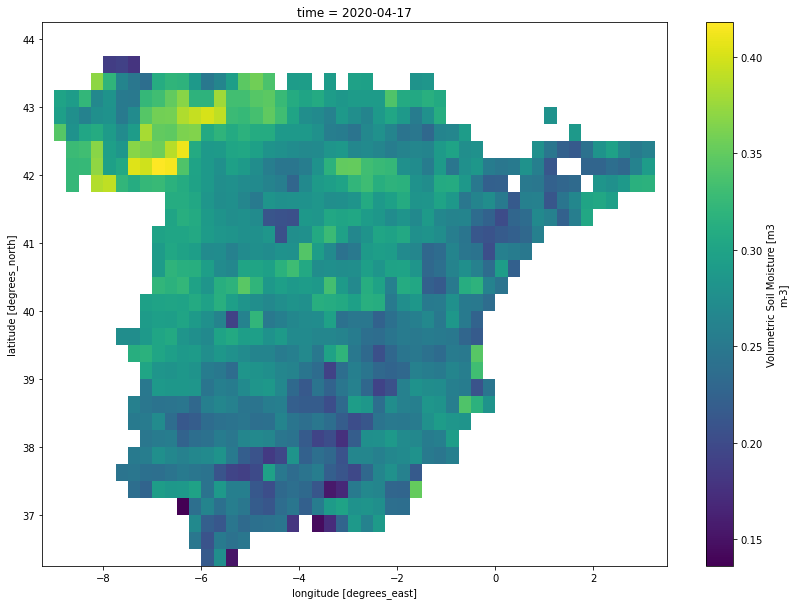

In [14]:
# Let's have a look just at one of the time slices
sm_dataset_subset.sm.sel(time="2020-04-17", method='nearest').plot.imshow(figsize=(14, 10))

_We first compute annual averages from daily data, then aggregate over Spain:_

In [16]:
# calculate the annual average soil moisture for every grid cell of Spain
sm_dataset_subset_annual = sm_dataset_subset.resample(time='1Y').mean()
# calculate the annual average for whole Spain
sm_dataset_subset_annual_country = sm_dataset_subset_annual.mean(("lat","lon"))

_Plot the time series for whole Spain:_

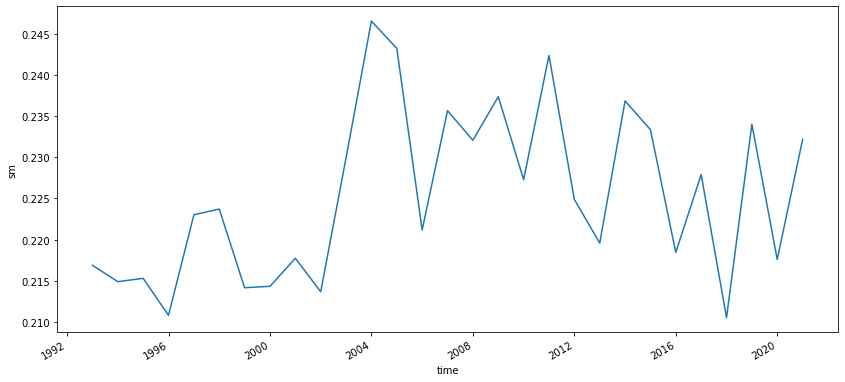

In [17]:
sm_dataset_subset_annual_country.sm.plot(figsize=(14, 6))

_Plot the time series for Valencia only:_

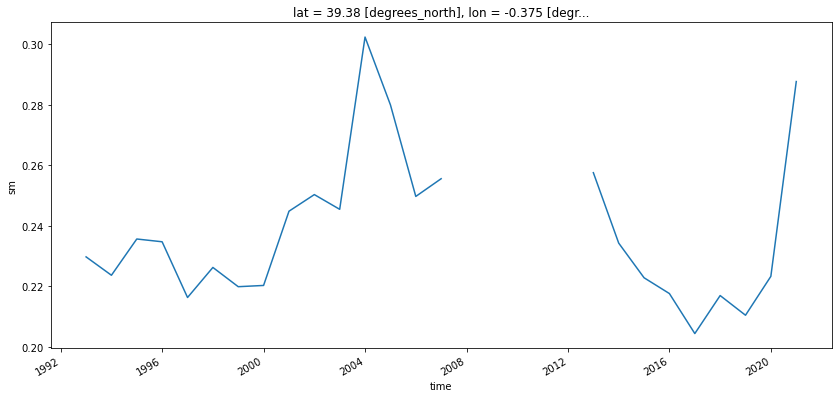

In [18]:
sm_dataset_subset_annual.sel(valencia, method="nearest").sm.plot(figsize=(14, 6))

---
### Land Cover ECV

_Tourism and agriculture are important factors in Spain's economy. The landscape of the country mirrors this with its beautiful coasts  
and the large croplands in the Hinterland. However, the climate change is impacting both. The ECVs Land Cover and soil moisture  
allow us to inspect if we can observe already now changes of the land's surface characteristics._  

_We will now add to our notebook the Land Cover dataset included in the Open Data Portal._  

_As with the Soil Moisture, the dataset includes are large number of variables and we drop those not needed for this Masterclass.  
When we inspect the dataset we see that it covers the globe in much high spatial resolution than the Soil Moisture (300m at the equator)  
resulting in a very large grid of 129 600 cells in longitude and 64 800 cells in latitude._  

_The land cover is the long term stable component of the landscape and it is derived from analysing the annual cycle of the colour of the surface and a thorough analysis of potential change. Thus, the dataset have an annual time step. The CCI LC dataset spans from 1992 to 2015 and is derived in harmonised way from multiple satelllite missions._

In [20]:
drop_variables = ['change_count', 'current_pixel_state', 'observation_count', 'processed_flag']  # Not needed
lc_dataset = store.open_data('ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
                             drop_variables=drop_variables)
lc_dataset = time_to_year(lc_dataset) # this is a helper-function to map the time coordinate to a full year instead of a single day of a year
lc_dataset

,Array,Chunk
Bytes,750.85 GiB,12.81 MiB
Shape,"(24, 64800, 129600)","(1, 2592, 1296)"
Count,60001 Tasks,60000 Chunks
Type,float32,numpy.ndarray


_We create the spatial subset over Spain using the same geometry as for soil moisture. We have a look  
at the land cover 20 years ago, when the MERIS instrument onboard ENVISAT allowed for first time to derive  
a true 300m land cover map._

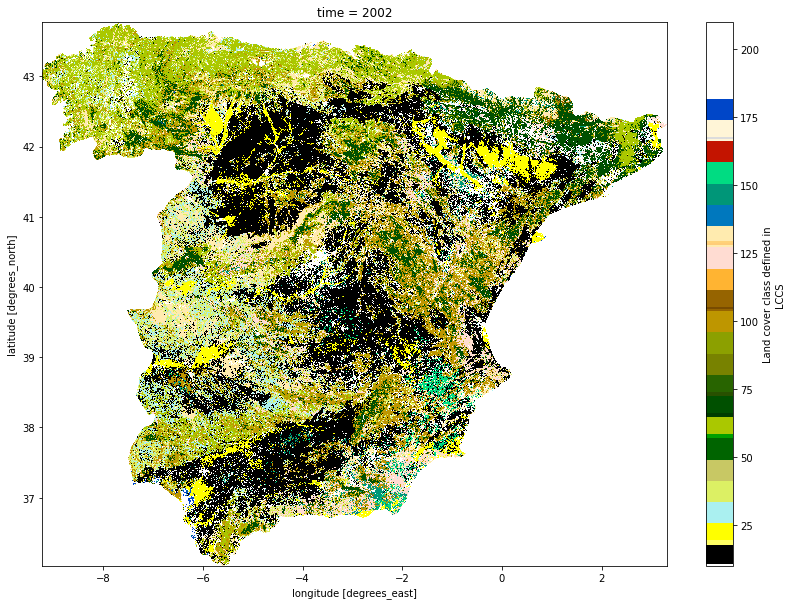

In [21]:
lc_dataset_subset = mask_dataset_by_geometry(lc_dataset, desired_geometry, all_touched=True)
lc_dataset_subset.sel(time=2002).lccs_class.plot.imshow(cmap='land_cover_cci', figsize=(14, 10))

__Now we want to see which are the most frequent land cover classes in Spain.
First, get us the names of the Land Cover Classes__

In [22]:
lc = lc_dataset_subset.sel(time=2015).lccs_class #we pick an arbitrary year, just to get the names
flag_values = [(fv if fv >= 0 else 256 + fv) for fv in lc.attrs['flag_values']]
list(zip(lc.attrs['flag_meanings'].split(' '), flag_values))

[('no_data', 0),
 ('cropland_rainfed', 10),
 ('cropland_rainfed_herbaceous_cover', 11),
 ('cropland_rainfed_tree_or_shrub_cover', 12),
 ('cropland_irrigated', 20),
 ('mosaic_cropland', 30),
 ('mosaic_natural_vegetation', 40),
 ('tree_broadleaved_evergreen_closed_to_open', 50),
 ('tree_broadleaved_deciduous_closed_to_open', 60),
 ('tree_broadleaved_deciduous_closed', 61),
 ('tree_broadleaved_deciduous_open', 62),
 ('tree_needleleaved_evergreen_closed_to_open', 70),
 ('tree_needleleaved_evergreen_closed', 71),
 ('tree_needleleaved_evergreen_open', 72),
 ('tree_needleleaved_deciduous_closed_to_open', 80),
 ('tree_needleleaved_deciduous_closed', 81),
 ('tree_needleleaved_deciduous_open', 82),
 ('tree_mixed', 90),
 ('mosaic_tree_and_shrub', 100),
 ('mosaic_herbaceous', 110),
 ('shrubland', 120),
 ('shrubland_evergreen', 121),
 ('shrubland_deciduous', 122),
 ('grassland', 130),
 ('lichens_and_mosses', 140),
 ('sparse_vegetation', 150),
 ('sparse_tree', 151),
 ('sparse_shrub', 152),
 ('sparse

_Now we count the pixels per class. This translates directly into an area: 1 pixels = 0.3 * 0.3 km².  
In 2002, most area of Spain was "cropland_rainfed_herbaceous_cover". All cropland classes together had a total area of 280 km² (50% of the total area).  
In 2015, the cropland area had decreased by 0.5%. On the other hand, the shrubland and urban areas had increased. This time difference of 13 years is too short in order to conclude on climate change, though._

In [ ]:
year = 2015
lc_counts = sort_lc(lc_dataset_subset, year)
sorted([(int(item.lccs_class), int(item)) for item in lc_counts], key=lambda k: k[1], reverse=True)

In [ ]:
year = 2002
lc_counts = sort_lc(lc_dataset_subset, year)
sorted([(int(item.lccs_class), int(item)) for item in lc_counts], key=lambda k: k[1], reverse=True)

__Now we look at the time series of number of pixels (=area) of the 4 most important land cover classes_

In [37]:
def get_lc_counts_timeseries(lc_mask):
    return lc_mask.where(lc_mask).count(dim=('lat', 'lon'))

In [38]:
lcc = lc_dataset_subset.lccs_class

lc_masks_and_names = [
    ((lcc >= 100) & (lcc <= 130), 'Shrubland'),
    ((lcc >= 200) & (lcc <= 240), 'Bare Areas'),
    ((lcc >= 10) & (lcc <= 30), 'Cropland'),
    ((lcc >= 50) & (lcc <= 90), 'Trees'),
]

lc_masks, lc_mask_names = zip(*lc_masks_and_names)
lc_masks, lc_mask_names = list(lc_masks), list(lc_mask_names)

In [39]:
lc_timeseries = [get_lc_counts_timeseries(lc_mask) for lc_mask in lc_masks]
lc_ts = xr.concat(lc_timeseries, "lcc")
lc_ts = lc_ts.assign_coords(lcc=xr.DataArray(lc_mask_names, dims="lcc"))

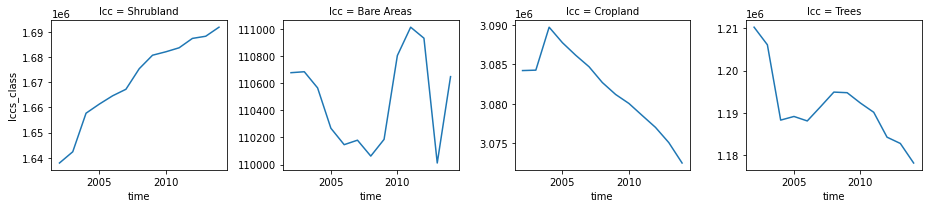

In [40]:
lc_ts[:,10:23].plot.line(x="time", col='lcc', col_wrap=4, sharey=False)

#### ToDo: 
#### (1) plot the time series of annual SM for those pixels which are cropland in 2015 (i.e. those pixels which were cropland all the tinme)
#### (2) plot the time series of annual SM for those pixels which were cropland in 2002 but not in 2015